<a href="https://colab.research.google.com/github/Trickshotblaster/nn-practices/blob/main/actual_words.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

In [ ]:
!pip install transformers

In [204]:

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [205]:
tokenizer.vocab_size

30522

In [206]:
output = tokenizer.encode("Hello, y'all! How are you 😁 ?")
out_tensor = torch.tensor(output)

In [207]:
out_tensor

tensor([ 101, 7592, 1010, 1061, 1005, 2035,  999, 2129, 2024, 2017,  100, 1029,
         102])

In [208]:
tokenizer.decode(out_tensor)

"[CLS] hello, y'all! how are you [UNK]? [SEP]"

In [7]:
import requests
import io

# Get the content of the page
response = requests.get("https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt")

# Write the content to a file
with io.open('traintext.txt', 'w', encoding='utf-8') as f:
    f.write(response.text)

In [8]:
with open("traintext.txt", 'r') as f:
  text = f.readlines()

In [9]:
text[:10]

['First Citizen:\n',
 'Before we proceed any further, hear me speak.\n',
 '\n',
 'All:\n',
 'Speak, speak.\n',
 '\n',
 'First Citizen:\n',
 'You are all resolved rather to die than to famish?\n',
 '\n',
 'All:\n']

In [10]:
import random

In [11]:
text_len = len(text) - 1

In [227]:
context_len = 1
emb_dim = 20
#tokenizer.enable_truncation(context_len)
#tokenizer.enable_padding(direction='left', length=context_len)

pretokenize? aaaa but it takes so long

In [137]:
pretokenized_text = [tokenizer.encode(t) for t in text]

In [211]:
tokenizer.decode([101])

'[CLS]'

In [209]:
pretokenized_text[:10]

[[101, 2034, 6926, 1024, 102],
 [101, 2077, 2057, 10838, 2151, 2582, 1010, 2963, 2033, 3713, 1012, 102],
 [101, 102],
 [101, 2035, 1024, 102],
 [101, 3713, 1010, 3713, 1012, 102],
 [101, 102],
 [101, 2034, 6926, 1024, 102],
 [101,
  2017,
  2024,
  2035,
  10395,
  2738,
  2000,
  3280,
  2084,
  2000,
  6904,
  15630,
  2232,
  1029,
  102],
 [101, 102],
 [101, 2035, 1024, 102]]

In [14]:
vocab_size = tokenizer.vocab_size

In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [16]:
tokenizer.pad_token_id

0

In [228]:
def make_batch(batch):
  xs = []
  ys = []
  for sentence in batch:
    context = [0] * context_len
    for word, next in zip(sentence, sentence[1:]):
      context = context[1:] + [word]
      xs.append(context)
      ys.append(next)
  xs = torch.tensor(xs).to(device)
  ys = torch.tensor(ys).to(device)
  return xs, ys

In [152]:
n_hidden = 500

In [232]:
C = torch.randn((vocab_size, emb_dim)).to(device)
w1 = torch.randn((emb_dim * context_len, n_hidden)).to(device) * 0.01
b1 = torch.randn(n_hidden).to(device) * 0.01
w2 = torch.randn((n_hidden, vocab_size)).to(device) * 0.01
b2 = torch.randn(vocab_size).to(device) * 0.01

bngain = torch.ones((1, n_hidden)).to(device)
bnbias = torch.zeros((1, n_hidden)).to(device)

params = [C, w1, b1, w2, b2, bngain, bnbias]
weights = [w1, w2]
for p in params:
  p.requires_grad = True

print("Parameters:", sum(len(p) for p in params))

Parameters: 62066


In [141]:
import torch.nn.functional as F

In [230]:
num_epochs = 20000
batch_size = 32
lr = 0.1

In [233]:
for epoch in range(num_epochs):
  batch = [pretokenized_text[random.randint(0, text_len)] for i in range(batch_size)]
  #words = torch.tensor([tokenizer.encode_batch(batch)[i].ids for i in range(batch_size)])
  x, y = make_batch(batch)
  emb = C[x].view(-1, emb_dim * context_len)
  l1preact = emb @ w1 + b1

  l1preact = bngain * (l1preact - l1preact.mean(0, keepdim=True)) / l1preact.std(0, keepdim=True) + bnbias
  l1 = l1preact.tanh()

  logits = l1 @ w2 + b2

  loss = F.cross_entropy(logits, y) + (torch.tensor([w.mean() for w in weights]).mean()) * 2

  for p in params:
    p.grad = None

  loss.backward()
  for p in params:
    p.data -= p.grad * (lr / min(1, (1000/(epoch+1))))
  if epoch % 1000 == 0:
    print(loss.item())


10.34179401397705
6.052699565887451
5.201022624969482
4.629299163818359
5.307791233062744
4.9745306968688965
5.158914089202881
4.692965030670166
5.027287483215332
4.621493816375732
4.496150493621826
4.965137004852295
4.976150989532471
4.684900283813477
4.669144153594971
4.518394947052002
4.41860818862915
4.953644275665283
4.6691975593566895
4.625716209411621


In [186]:
loss.log10().item()

0.6270263195037842

In [103]:
import matplotlib.pyplot as plt

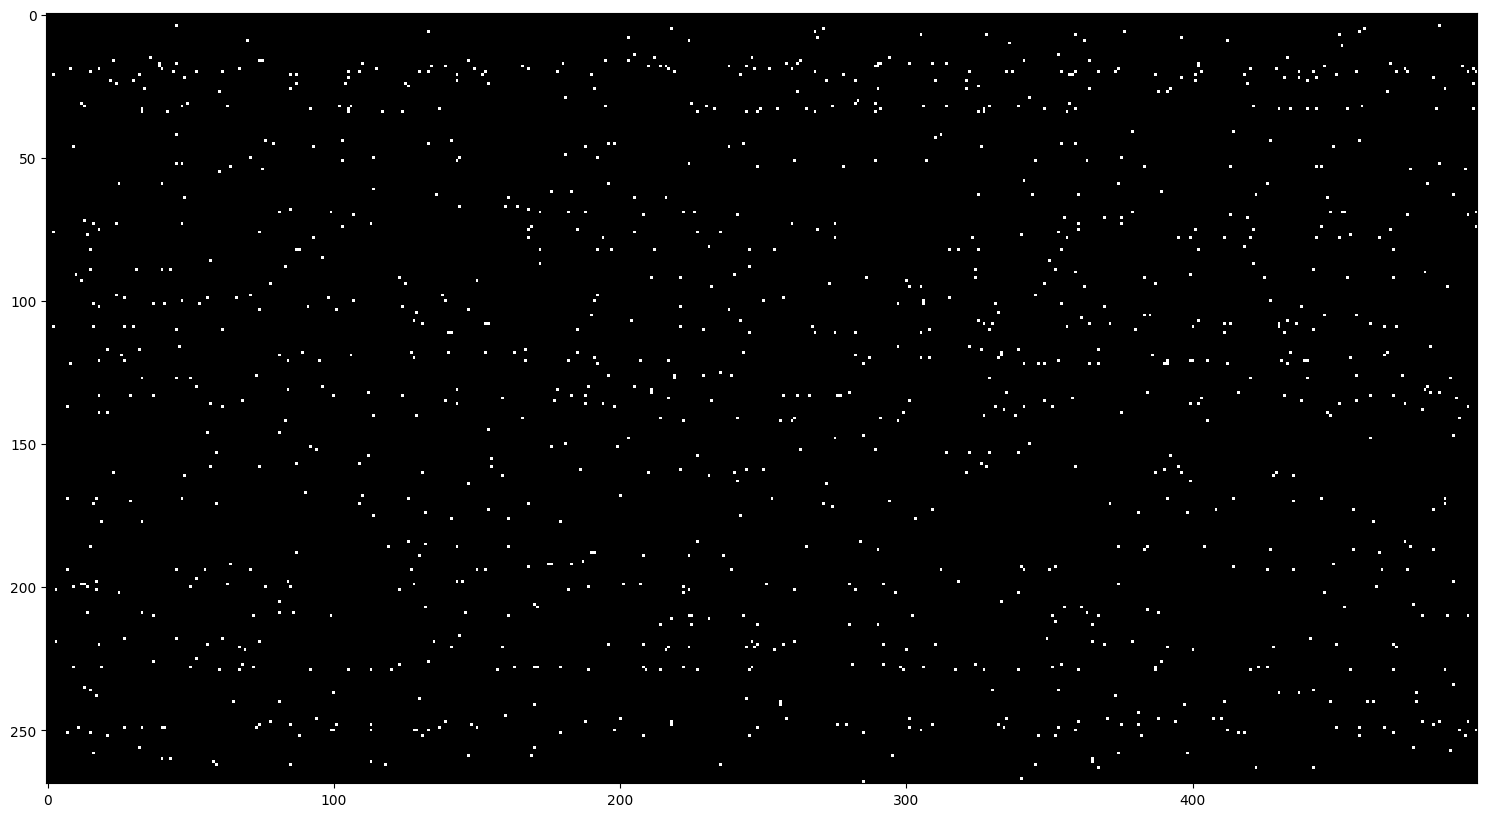

In [193]:
plt.figure(figsize=(20,10))
plt.imshow(l1.cpu().abs() > 0.99, cmap='gray', interpolation='nearest')

(array([33161.,  7616.,  6584.,  7167.,  8131.,  8691.,  6989.,  6704.,
         7749., 32708.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

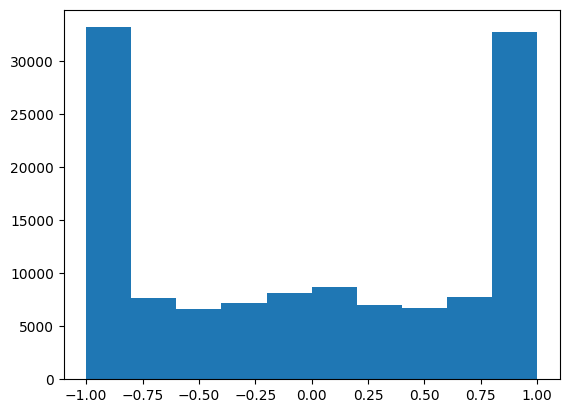

In [188]:
plt.hist(l1.view(-1).tolist())

In [180]:
@torch.no_grad()
def forward(text):
  ins = text
  x = tokenizer.encode(text)
  context = [0] * (context_len - len(x)) + x if (context_len - len(x)) > 0 else x[:-context_len]
  context = torch.tensor(context)
  emb = C[context].view(-1, emb_dim * context_len)
  l1 = (emb @ w1 + b1).tanh()
  out = l1 @ w2 + b2
  out = F.softmax(out, dim=1)
  sampled = torch.multinomial(out, num_samples=1)
  return sampled

In [179]:
def numerical_forward(cont):
  cont = torch.tensor(cont).to(device)
  emb = C[cont].view(-1, emb_dim * context_len)
  l1 = (emb @ w1 + b1).tanh()
  out = l1 @ w2 + b2
  out = F.softmax(out, dim=1)
  sampled = torch.multinomial(out, num_samples=1)
  return sampled

In [181]:
lol = forward('Romeo')
print(lol)
tokenizer.decode(lol[0][0])

tensor([[28228]], device='cuda:0')


'##rti'

ok this is actually crazy it said thou

In [109]:
tokenizer.vocab_size

30522

In [182]:
def cont(text, max_len=20):
  x = tokenizer.encode(text)
  context = [0] * (context_len - len(x)) + x if (context_len - len(x)) > 0 else x[:-context_len]
  out = []
  for x in range(max_len):
    out.append(numerical_forward(context).cpu().numpy()[0][0])
    context.append(numerical_forward(context).cpu().numpy()[0][0])
    context = context[1:]

  return tokenizer.decode(out)

cont("Romeo")

'##eries officelt [unused521]sam executivesgroomviousdscalave threaded tumble diplomacyntsppnetina falling'

In [173]:
def cont_random(text, max_len=20):
  return tokenizer.decode(torch.randint(0, tokenizer.vocab_size -1, (max_len, )))

cont_random("Romeo")

'##gawa barr conspiracy aires homage julius restricting financialtzer [unused775] fabian rica sammy bradford hiredinium hid caution earlier 212'

In [ ]:
tokenizer.encode("[UNK]")

[101, 100, 102]

In [ ]:
tokenizer.vocab_size

30522